对1872年至2022年国际足球成绩进行分析和预处理

In [3]:
import pandas as pd
import numpy as np 
import re

import os

# 获取当前所在目录的绝对路径
current_dir = os.getcwd()

# 将当前工作目录更改为脚本所在目录
os.chdir(current_dir)


df =  pd.read_csv("fifa/01/results.csv")

In [3]:
df.head()

date home_team away_team  home_score  away_score tournament     city  \
0  1872-11-30  Scotland   England           0           0   Friendly  Glasgow   
1  1873-03-08   England  Scotland           4           2   Friendly   London   
2  1874-03-07  Scotland   England           2           1   Friendly  Glasgow   
3  1875-03-06   England  Scotland           2           2   Friendly   London   
4  1876-03-04  Scotland   England           3           0   Friendly  Glasgow   

    country  neutral  
0  Scotland    False  
1   England    False  
2  Scotland    False  
3   England    False  
4  Scotland    False

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44341 entries, 0 to 44340
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        44341 non-null  object
 1   home_team   44341 non-null  object
 2   away_team   44341 non-null  object
 3   home_score  44341 non-null  int64 
 4   away_score  44341 non-null  int64 
 5   tournament  44341 non-null  object
 6   city        44341 non-null  object
 7   country     44341 non-null  object
 8   neutral     44341 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.7+ MB


In [5]:
#缺失值查看、
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [6]:
df = df.drop(df[df['date']=='2022-19-22'].index,axis=0)

In [7]:
#删除缺失值所在的行
df.dropna(inplace=True)
#将日期列的格式转换为日期格式
df["date"] = pd.to_datetime(df["date"])

使用的数据集将是2018年国际足联奥运会，从2018年世界杯后到2022年世界杯前的最后一场比赛。这个想法是为了分析世界杯准备和分类阶段的比赛情况。

In [8]:
df.sort_values("date").tail()

date home_team    away_team  home_score  away_score  \
44336 2022-12-04   England      Senegal           3           0   
44337 2022-12-05     Japan      Croatia           1           1   
44338 2022-12-05    Brazil  South Korea           4           1   
44339 2022-12-06   Morocco        Spain           0           0   
44340 2022-12-06  Portugal  Switzerland           6           1   

           tournament       city country  neutral  
44336  FIFA World Cup    Al Khor   Qatar     True  
44337  FIFA World Cup  Al Wakrah   Qatar     True  
44338  FIFA World Cup       Doha   Qatar     True  
44339  FIFA World Cup  Al Rayyan   Qatar     True  
44340  FIFA World Cup     Lusail   Qatar     True

In [9]:
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True)

In [10]:
df.sort_values("date").tail()

date home_team    away_team  home_score  away_score  \
3914 2022-12-04   England      Senegal           3           0   
3915 2022-12-05     Japan      Croatia           1           1   
3916 2022-12-05    Brazil  South Korea           4           1   
3917 2022-12-06   Morocco        Spain           0           0   
3918 2022-12-06  Portugal  Switzerland           6           1   

          tournament       city country  neutral  
3914  FIFA World Cup    Al Khor   Qatar     True  
3915  FIFA World Cup  Al Wakrah   Qatar     True  
3916  FIFA World Cup       Doha   Qatar     True  
3917  FIFA World Cup  Al Rayyan   Qatar     True  
3918  FIFA World Cup     Lusail   Qatar     True

对国际足联世界排名1992-2022的数据集进行分析和预处理

In [133]:
rank = pd.read_csv("fifa/02/fifa_ranking-2022-10-06.csv")

In [135]:
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True)

世界杯上的一些球队在排名数据集中有不同的名字。所以，它需要调整。

In [137]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

两表进行Merge

将日期设置为我们的索引，然后根据国家进行分组，再重新采样每一天的第一条数据作为我们的数据，最后重置索引

In [154]:
#将日期设置为我们的索引，然后根据国家进行分组，再重新采样每一天的第一条数据作为我们的数据，最后重置索引
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [155]:
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]],
 left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

In [156]:
df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], 
left_on=["date", "away_team"], right_on=["rank_date", "country_full"], 
suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

/var/folders/kk/jvv16s9j1nv71m7h0r1399lh0000gn/T/ipykernel_1247/909155552.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'previous_points_home', 'total_points_home', 'rank_home', 'rank_change_home'} in the result is deprecated and will raise a MergeError in a future version.
  df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]],


In [157]:
df_wc_ranked[(df_wc_ranked.home_team == "Brazil") | (df_wc_ranked.away_team == "Brazil")].tail()

date    home_team away_team  home_score  away_score  \
2896 2022-03-29      Bolivia    Brazil           0           4   
2988 2022-06-02  South Korea    Brazil           1           5   
3056 2022-06-06        Japan    Brazil           0           1   
3234 2022-09-23       Brazil     Ghana           3           0   
3303 2022-09-27       Brazil   Tunisia           5           1   

                        tournament      city      country  neutral  \
2896  FIFA World Cup qualification    La Paz      Bolivia    False   
2988                      Friendly     Seoul  South Korea    False   
3056                      Friendly     Tokyo        Japan    False   
3234                      Friendly  Le Havre       France     True   
3303                      Friendly     Paris       France     True   

      total_points_home  ...  rank_away  rank_change_away  total_points_home  \
2896            1308.12  ...        2.0               0.0            1308.12   
2988            1519.54  ...        1.0              -1.0            1519.54   
3056            1553.44  ...        1.0              -1.0            1553.44   
3234            1837.56  ...       60.0               0.0            1837.56   
3303            1837.56  ...       30.0               0.0            1837.56   

      previous_points_home  rank_home  rank_change_home  total_points_away  \
2896               1324.21       76.0              -1.0            1823.42   
2988               1522.85       29.0               0.0            1832.69   
3056               1549.82       23.0               0.0            1832.69   
3234               1837.56        1.0               0.0            1393.47   
3303               1837.56        1.0               0.0            1507.86   

      previous_points_away  rank_away  rank_change_away  
2896               1826.35        2.0               0.0  
2988               1823.42        1.0              -1.0  
3056               1823.42        1.0              -1.0  
3234               1389.68       60.0               0.0  
3303               1507.86       30.0               0.0  

[5 rows x 40 columns]

In [163]:
df_wc_ranked[['home_team','away_team','home_score','away_score',"result", "home_team_points", "away_team_points"]]

home_team             away_team  home_score  away_score  result  \
0       Andorra  United Arab Emirates           0           0       2   
1       Grenada               Jamaica           1           5       1   
2     Guatemala                  Cuba           1           0       0   
3      Barbados               Jamaica           2           2       2   
4      Barbados                  Cuba           0           0       2   
...         ...                   ...         ...         ...     ...   
3334     Norway                Serbia           0           2       1   
3335     Sweden              Slovenia           1           1       2   
3336     Kosovo                Cyprus           5           1       0   
3337     Greece      Northern Ireland           3           1       0   
3338       Fiji       Solomon Islands           1           0       0   

      home_team_points  away_team_points  
0                    1                 1  
1                    0                 3  
2                    3                 0  
3                    1                 1  
4                    1                 1  
...                ...               ...  
3334                 0                 3  
3335                 1                 1  
3336                 3                 0  
3337                 3                 0  
3338                 3                 0  

[3339 rows x 7 columns]

特征工程

    这是的想法是创造更多对足球比赛胜负有影响的特征
    我们认为影响的特征可能是以下几个: 1.球队的历史得分 2.球队历史的进球与失球 3.球队的排名 4.球队排名的上升情况 5.排名所面临的进球和损失 6.比赛的重要性（是否友好）
    因此我们要创建一个功能：判断哪支队赢了，以及他们在比赛中获得了多少分


In [149]:
df = df_wc_ranked
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)
df[["result", "home_team_points", "away_team_points"]] = results

In [152]:
df[['home_team_points']]

home_team_points
0                    1
1                    0
2                    3
3                    1
4                    1
...                ...
3334                 0
3335                 1
3336                 3
3337                 3
3338                 3

[3339 rows x 1 columns]

In [88]:
df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr()

total_points_home  rank_home  total_points_away  rank_away
total_points_home           1.000000  -0.990583           0.503614  -0.503681
rank_home                  -0.990583   1.000000          -0.498945   0.502419
total_points_away           0.503614  -0.498945           1.000000  -0.991357
rank_away                  -0.503681   0.502419          -0.991357   1.000000

相关系数

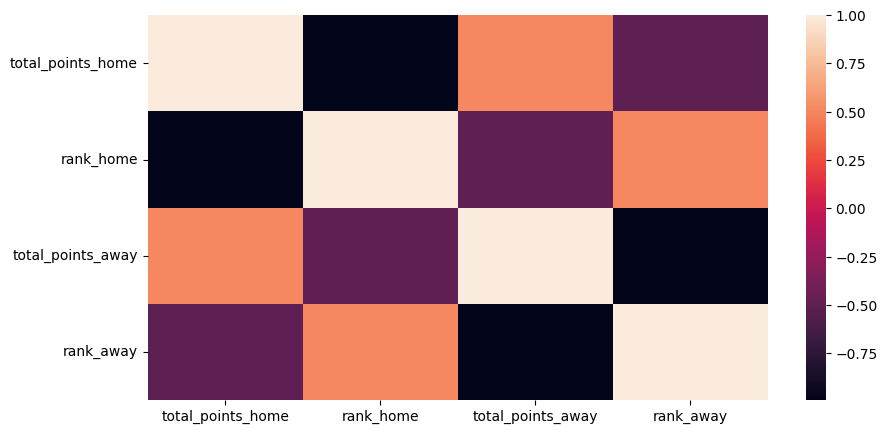

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 5))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr())
plt.show()

In [20]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]  #排名差异
df["sg"] = df["home_score"] - df["away_score"]  #分数差异
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"] #主场队伍进球与排名的关系
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"] #客场队伍进球与排名的关系

为了更好的特征衍生，我们将数据集分为主队和客队的数据集，然后合并一起计算它们过去比赛的各种特征。 之后再将它们分离并合并，构造出一个原始的数据集。 这个过程优化了特征衍生

In [21]:
#先分离数据集
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [22]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [23]:
team_stats = home_team.append(away_team)

/var/folders/kk/jvv16s9j1nv71m7h0r1399lh0000gn/T/ipykernel_1247/2656291173.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_stats = home_team.append(away_team)


In [165]:
team_stats

date              team  score  suf_score   rank  rank_suf  \
0    2018-08-18           Andorra      0          0  130.0      77.0   
1    2018-08-18           Grenada      1          5  168.0      54.0   
2    2018-08-18         Guatemala      1          0  146.0     181.0   
3    2018-08-20          Barbados      2          2  160.0      54.0   
4    2018-08-26          Barbados      0          0  160.0     181.0   
...         ...               ...    ...        ...    ...       ...   
3334 2022-09-27            Serbia      2          0   25.0      36.0   
3335 2022-09-27          Slovenia      1          1   65.0      20.0   
3336 2022-09-27            Cyprus      1          5  108.0     106.0   
3337 2022-09-27  Northern Ireland      1          3   58.0      49.0   
3338 2022-09-30   Solomon Islands      0          1  137.0     163.0   

      rank_change  total_points  result  rank_dif  points_by_rank  team_points  
0             0.0       1120.00       2      53.0        0.012987            1  
1             0.0        980.00       1     114.0        0.000000            0  
2             0.0       1064.00       0     -35.0        0.016575            3  
3             0.0       1005.00       2     106.0        0.018519            1  
4             0.0       1005.00       2     -21.0        0.005525            1  
...           ...           ...     ...       ...             ...          ...  
3334          0.0       1549.53       1      11.0        0.083333            3  
3335          0.0       1372.48       2     -45.0        0.050000            1  
3336          1.0       1180.52       0      -2.0        0.000000            0  
3337          0.0       1399.10       0      -9.0        0.000000            0  
3338          0.0       1092.56       0      26.0        0.000000            0  

[6678 rows x 12 columns]

In [24]:
team_stats_raw = team_stats.copy()

得到数据集后，进行第二次特征衍生

In [25]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5) #取出过去五场比赛
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [164]:
past_games

date             team  score  suf_score   rank  rank_suf  \
3256 2022-09-24  Solomon Islands      2          2  137.0     163.0   
3208 2022-09-21  Solomon Islands      1          0  137.0     160.0   
2940 2022-03-30  Solomon Islands      0          5  142.0     111.0   
2870 2022-03-27  Solomon Islands      3          2  142.0     165.0   
2809 2022-03-24  Solomon Islands      3          1  142.0     159.0   
2781 2022-03-17  Solomon Islands      2          0  142.0     190.0   
824  2019-07-18  Solomon Islands      4          4  140.0     167.0   
817  2019-07-15  Solomon Islands     13          0  140.0     190.0   
812  2019-07-12  Solomon Islands      0          3  140.0     158.0   
808  2019-07-10  Solomon Islands      0          2  140.0     155.0   
652  2019-06-08  Solomon Islands      3          4  139.0     160.0   
459  2019-03-18  Solomon Islands      3          1  143.0     163.0   
13   2018-09-05  Solomon Islands      1          1  143.0     165.0   
7    2018-08-29  Solomon Islands      4          1  143.0     185.0   

      rank_change  total_points  result  rank_dif  points_by_rank  team_points  
3256          0.0       1092.56       2      26.0        0.006135            1  
3208          0.0       1092.56       0     -23.0        0.018750            3  
2940          1.0       1072.78       1      31.0        0.000000            0  
2870          1.0       1072.78       0     -23.0        0.018182            3  
2809          1.0       1072.78       0     -17.0        0.018868            3  
2781          1.0       1072.78       1      48.0        0.015789            3  
824           1.0       1077.00       2      27.0        0.005988            1  
817           1.0       1077.00       0     -50.0        0.015789            3  
812           1.0       1077.00       1     -18.0        0.000000            0  
808           1.0       1077.00       1     -15.0        0.000000            0  
652          -4.0       1083.00       0      21.0        0.000000            0  
459          -1.0       1073.00       0     -20.0        0.018405            3  
13            0.0       1072.00       2      22.0        0.006061            1  
7             0.0       1072.00       1      42.0        0.016216            3

In [26]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [170]:
stats_df

goals_mean  goals_mean_l5  goals_suf_mean  goals_suf_mean_l5  \
0            NaN            NaN             NaN                NaN   
1            NaN            NaN             NaN                NaN   
2            NaN            NaN             NaN                NaN   
3            NaN            NaN             NaN                NaN   
4       2.000000            2.0        2.000000                2.0   
...          ...            ...             ...                ...   
6673    1.800000            2.2        1.111111                1.0   
6674    1.380952            1.0        1.000000                1.8   
6675    0.767442            0.6        1.767442                1.4   
6676    1.023256            1.2        1.279070                1.4   
6677    2.785714            1.8        1.857143                2.0   

       rank_mean  rank_mean_l5  points_mean  points_mean_l5  game_points_mean  \
0            NaN           NaN         0.00            0.00               NaN   
1            NaN           NaN         0.00            0.00               NaN   
2            NaN           NaN         0.00            0.00               NaN   
3            NaN           NaN         0.00            0.00               NaN   
4      54.000000          54.0         0.00            0.00          1.000000   
...          ...           ...          ...             ...               ...   
6673   54.533333          42.0        90.53            2.00          1.866667   
6674   76.357143          29.2       -19.52           -5.75          1.404762   
6675   70.418605          63.8       -99.48           -5.57          0.767442   
6676   57.906977          95.6       -92.90          -24.45          1.139535   
6677  163.642857         151.6        20.56           19.78          1.714286   

      game_points_mean_l5  game_points_rank_mean  game_points_rank_mean_l5  
0                     NaN                    NaN                       NaN  
1                     NaN                    NaN                       NaN  
2                     NaN                    NaN                       NaN  
3                     NaN                    NaN                       NaN  
4                     1.0               0.018519                  0.018519  
...                   ...                    ...                       ...  
6673                  2.0               0.053327                  0.073887  
6674                  1.0               0.026035                  0.029545  
6675                  1.0               0.009687                  0.019652  
6676                  1.0               0.022315                  0.009470  
6677                  2.0               0.010013                  0.012387  

[6678 rows x 12 columns]

In [27]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [28]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [29]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [30]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [31]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [32]:
a = ["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']
base_df = full_df[a]
base_df.head()

date  home_team             away_team  rank_home  rank_away  \
0 2018-08-18    Andorra  United Arab Emirates      130.0       77.0   
1 2018-08-18    Grenada               Jamaica      168.0       54.0   
2 2018-08-18  Guatemala                  Cuba      146.0      181.0   
3 2018-08-20   Barbados               Jamaica      160.0       54.0   
4 2018-08-26   Barbados                  Cuba      160.0      181.0   

   home_score  away_score  result  rank_dif  rank_change_home  ...  \
0           0           0       2      53.0               0.0  ...   
1           1           5       1     114.0               0.0  ...   
2           1           0       0     -35.0               0.0  ...   
3           2           2       2     106.0               0.0  ...   
4           0           0       2     -21.0               0.0  ...   

   home_game_points_mean  home_game_points_mean_l5  \
0                    NaN                       NaN   
1                    NaN                       NaN   
2                    NaN                       NaN   
3                    NaN                       NaN   
4                    1.0                       1.0   

   home_game_points_rank_mean  home_game_points_rank_mean_l5  \
0                         NaN                            NaN   
1                         NaN                            NaN   
2                         NaN                            NaN   
3                         NaN                            NaN   
4                    0.018519                       0.018519   

   away_game_points_mean  away_game_points_mean_l5  \
0                    NaN                       NaN   
1                    NaN                       NaN   
2                    NaN                       NaN   
3                    3.0                       3.0   
4                    0.0                       0.0   

   away_game_points_rank_mean  away_game_points_rank_mean_l5  is_friendly_0  \
0                         NaN                            NaN              0   
1                         NaN                            NaN              0   
2                         NaN                            NaN              0   
3                    0.017857                       0.017857              0   
4                    0.000000                       0.000000              0   

   is_friendly_1  
0              1  
1              1  
2              1  
3              1  
4              1  

[5 rows x 37 columns]

In [33]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                  101
home_goals_mean_l5               101
home_goals_suf_mean              101
home_goals_suf_mean_l5           101
home_rank_mean                   101
home_rank_mean_l5                101
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                  100
away_goals_mean_l5               100
away_goals_suf_mean              100
away_goals_suf_mean_l5           100
away_rank_mean                   100
away_rank_mean_l5                100
away_points_mean                   0
away_points_mean_l5                0
h

In [34]:
base_df_no_fg = base_df.dropna()

In [168]:
base_df_no_fg[['date','home_team','away_team','home_goals_suf_mean','away_goals_suf_mean','home_points_mean','away_points_mean']]

date   home_team         away_team  home_goals_suf_mean  \
4    2018-08-26    Barbados              Cuba             2.000000   
6    2018-08-29    Barbados              Cuba             1.000000   
31   2018-09-06    Mongolia              Guam             1.000000   
32   2018-09-06       Nepal            Bhutan             2.000000   
33   2018-09-06  Bangladesh          Pakistan             0.500000   
...         ...         ...               ...                  ...   
3334 2022-09-27      Norway            Serbia             0.880952   
3335 2022-09-27      Sweden          Slovenia             1.137255   
3336 2022-09-27      Kosovo            Cyprus             1.304348   
3337 2022-09-27      Greece  Northern Ireland             0.909091   
3338 2022-09-30        Fiji   Solomon Islands             1.222222   

      away_goals_suf_mean  home_points_mean  away_points_mean  
4                1.000000              0.00              0.00  
6                0.500000              0.00              0.00  
31               2.000000              0.00              0.00  
32               2.000000              0.00              0.00  
33               1.000000              0.00              0.00  
...                   ...               ...               ...  
3334             1.111111             82.57             90.53  
3335             1.000000             -1.56            -19.52  
3336             1.767442            103.90            -99.48  
3337             1.279070              5.45            -92.90  
3338             1.857143              8.37             20.56  

[3204 rows x 7 columns]

In [35]:
df = base_df_no_fg
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

/var/folders/kk/jvv16s9j1nv71m7h0r1399lh0000gn/T/ipykernel_1247/3132934783.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["result"].apply(lambda x: no_draw(x))


In [36]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [37]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

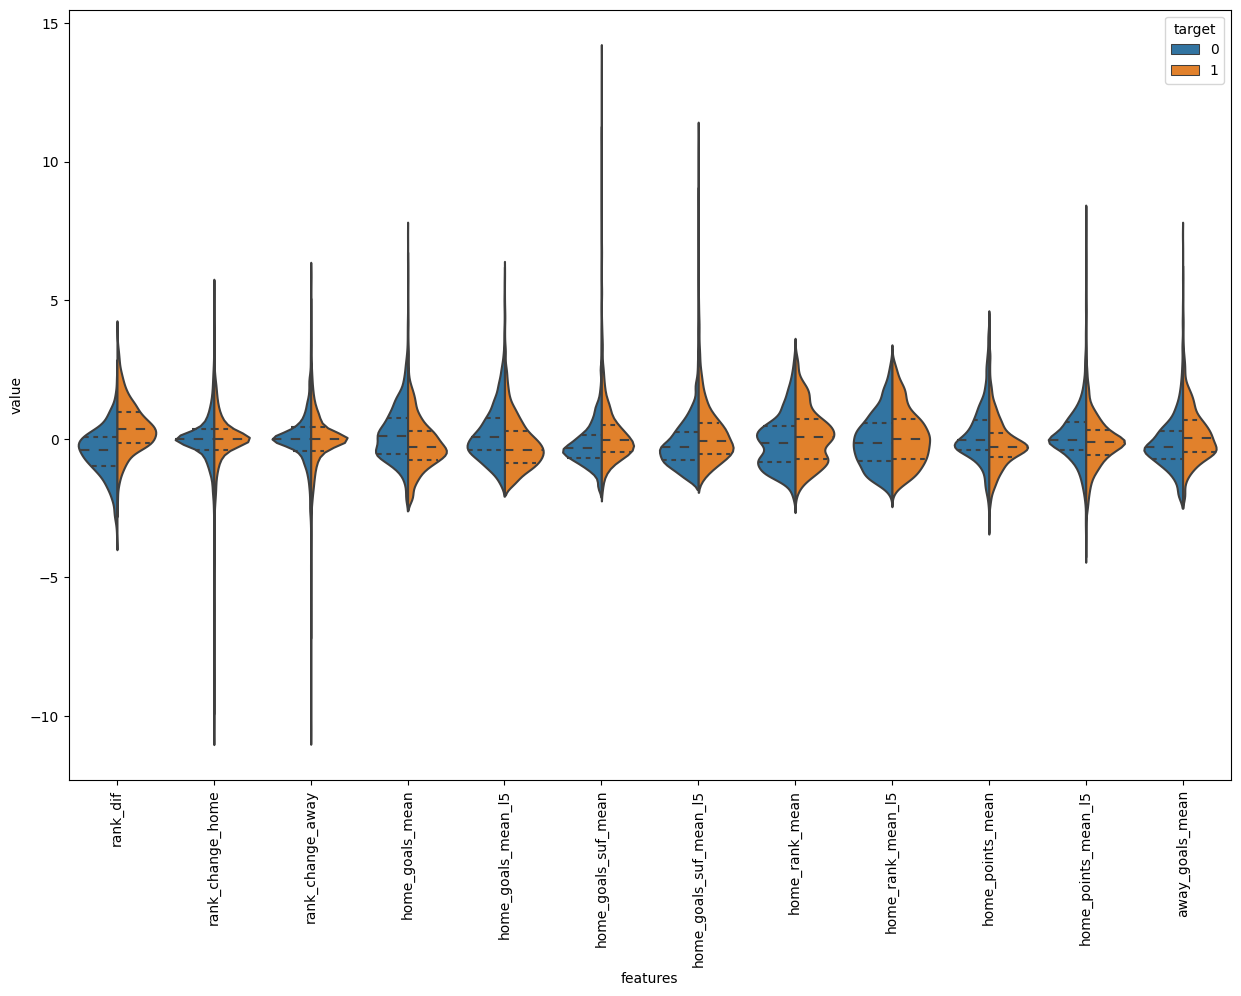

In [38]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

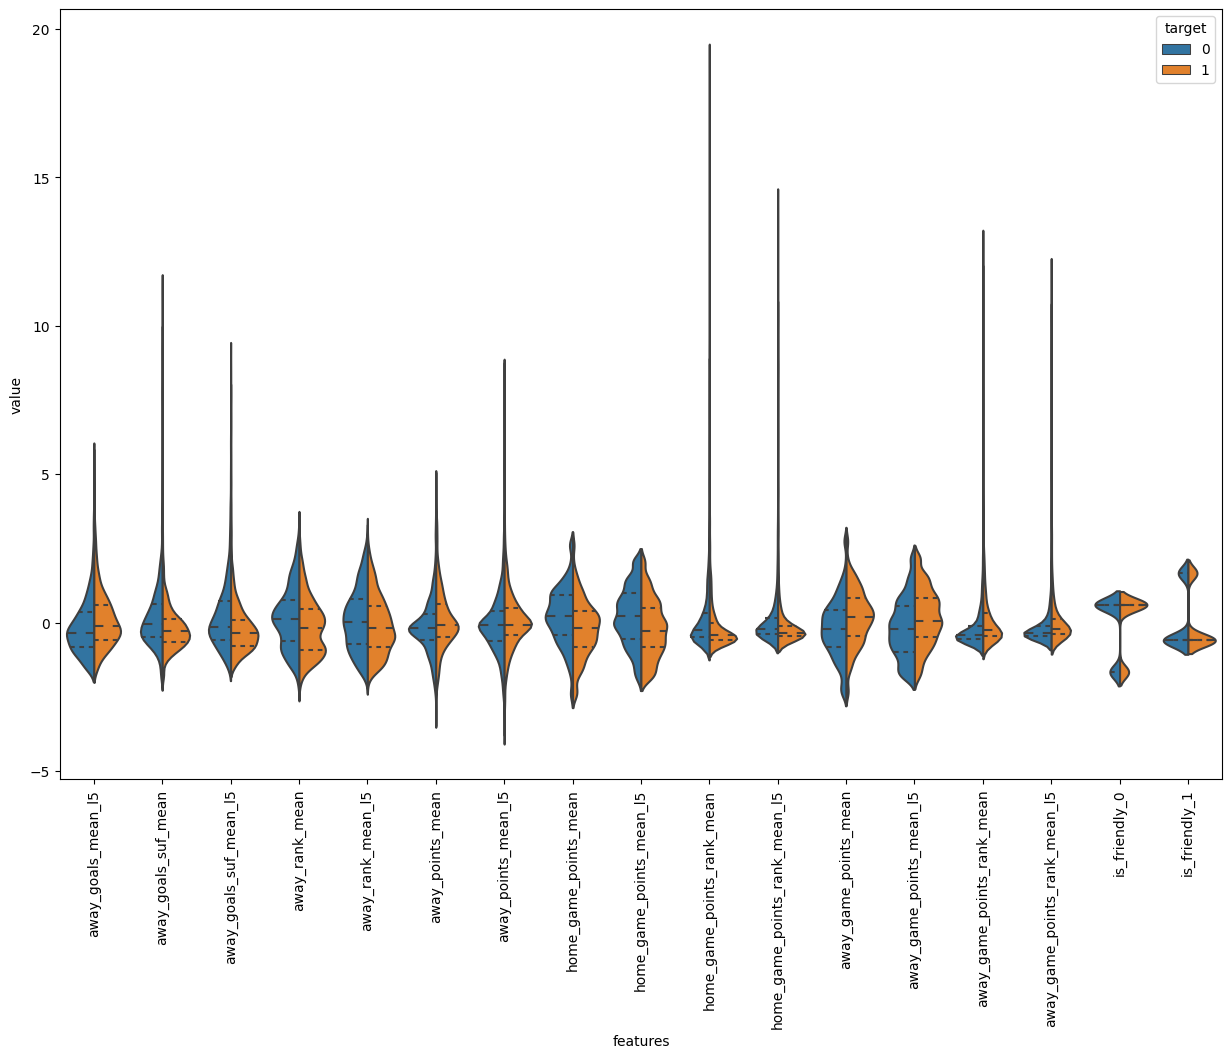

In [39]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

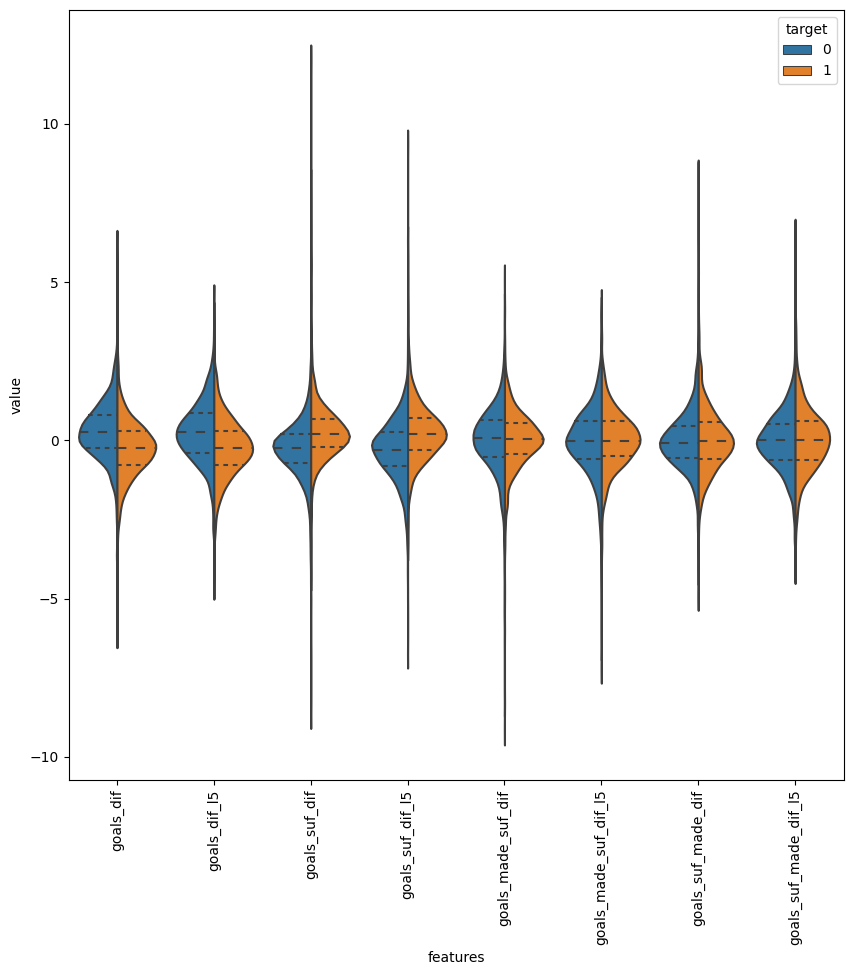

In [40]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

继续构建特征

In [41]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

In [42]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

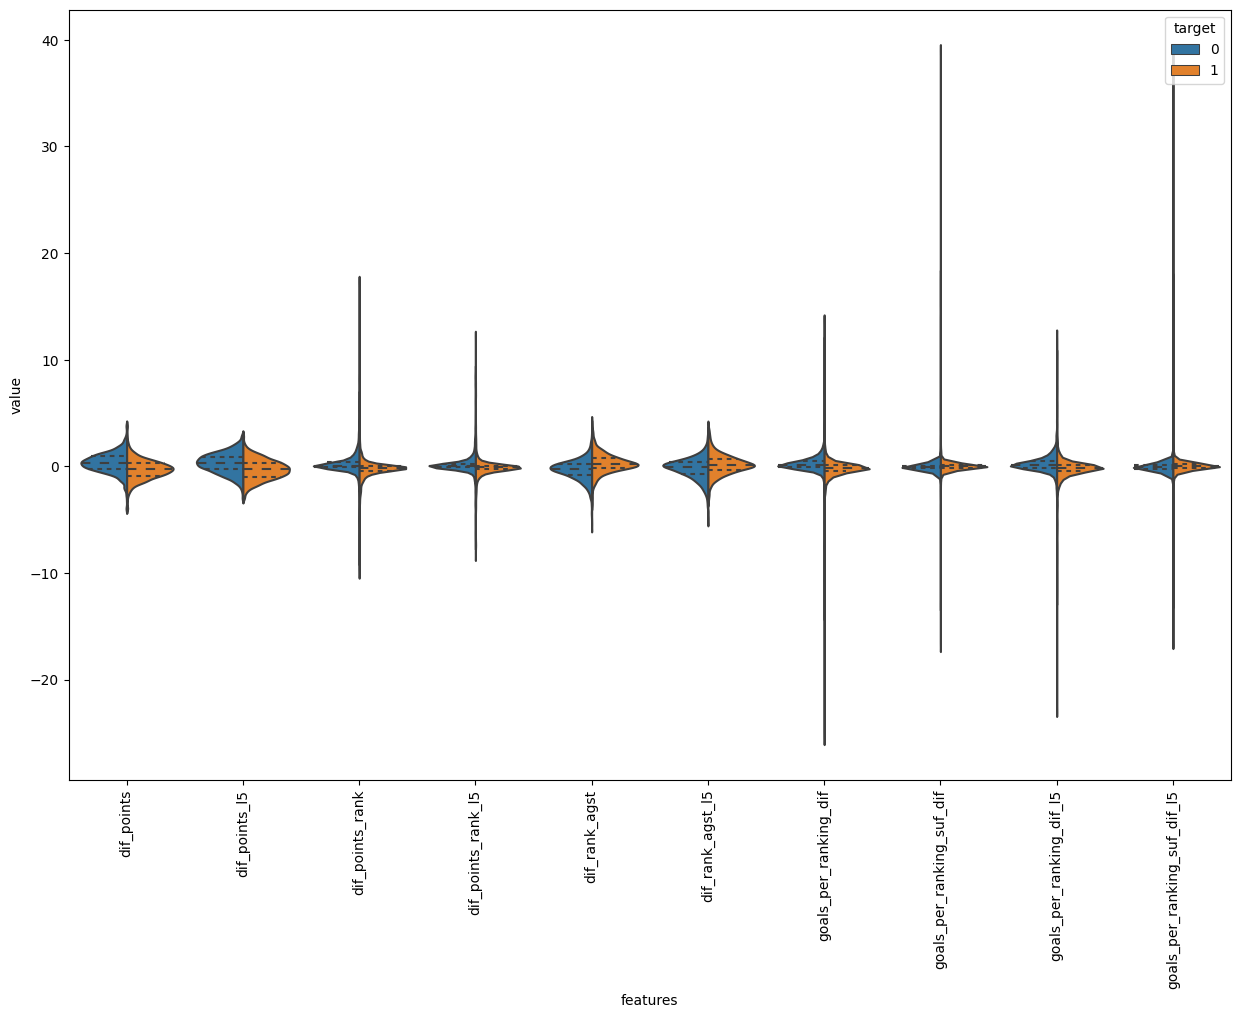

In [43]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

由于数值较低，小提琴图并不能很好的给我们反馈，因此对于这些特征，我们将使用箱线图

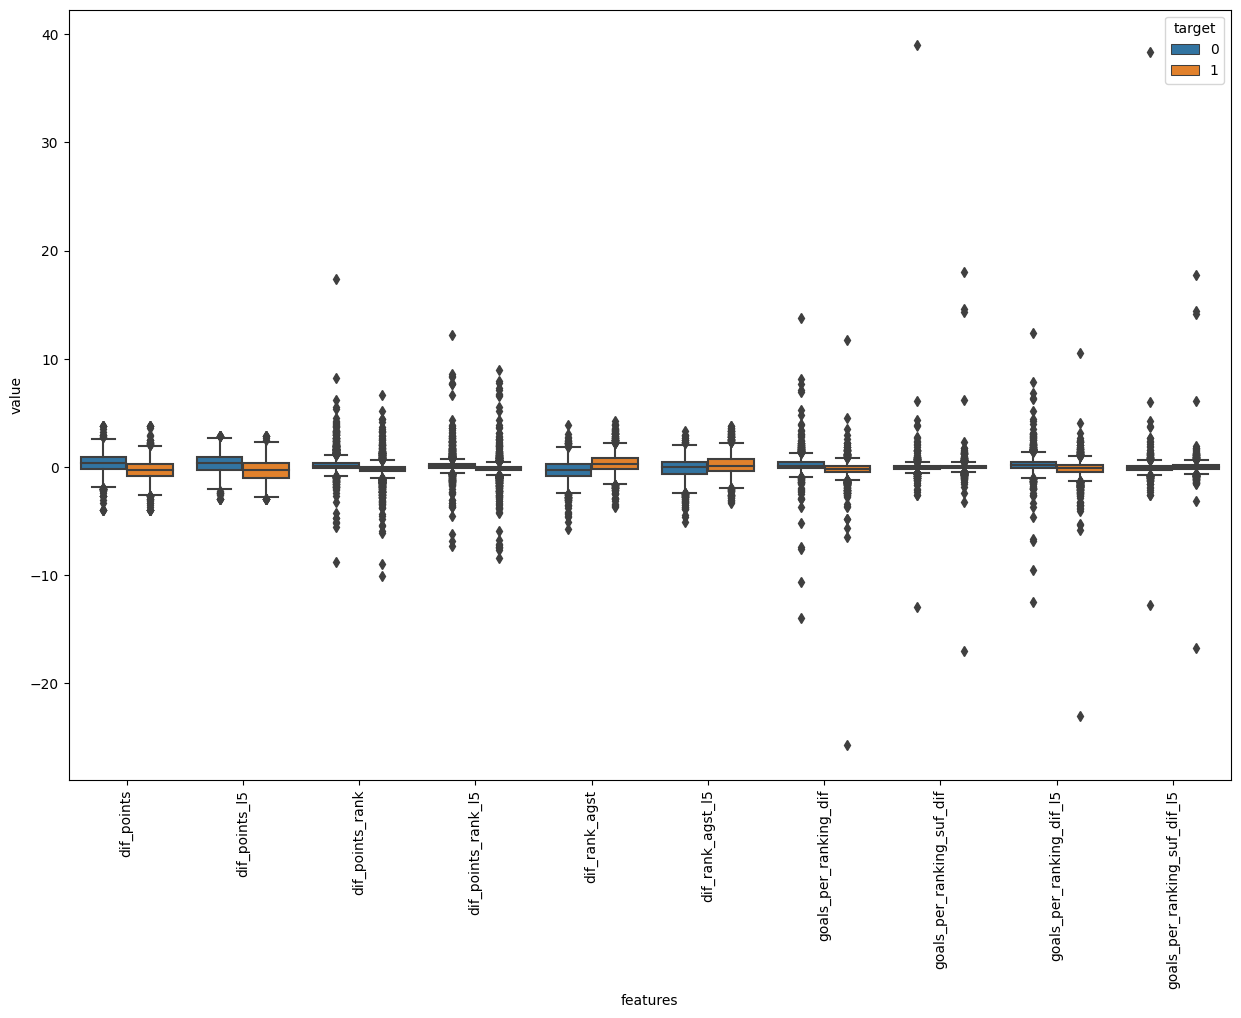

In [44]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()


    从中可以看出，Difference of points (所有比赛和最近5场比赛), difference of points by ranking faced (所有比赛和最近5场比赛) 和 difference of rank faced (所有比赛和最近5场比赛)是很好的特征。
    另外，一些衍生出来的特征具有非常相似的分布，对于这些特征，我们将使用散点图进行分析。



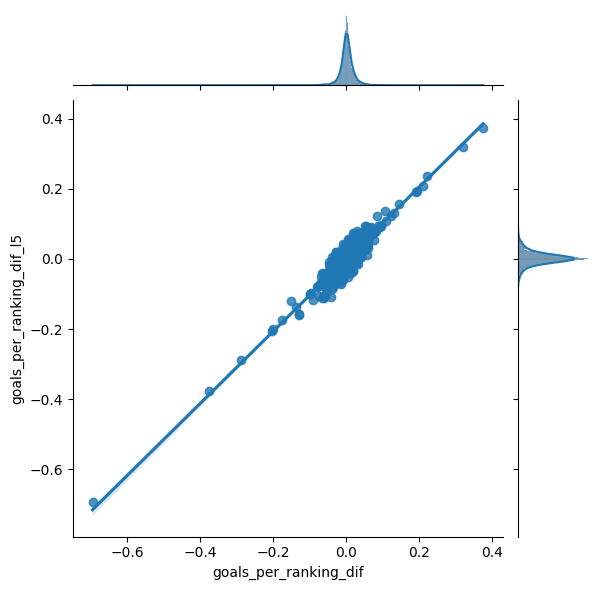

In [45]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

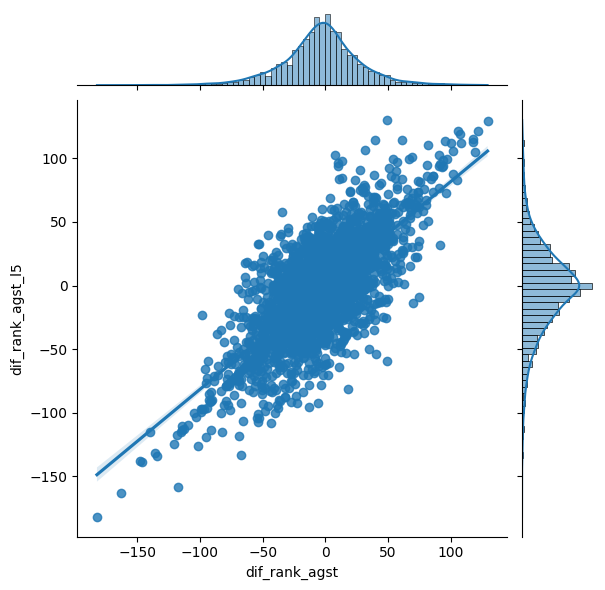

In [46]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l5', kind="reg")
plt.show()

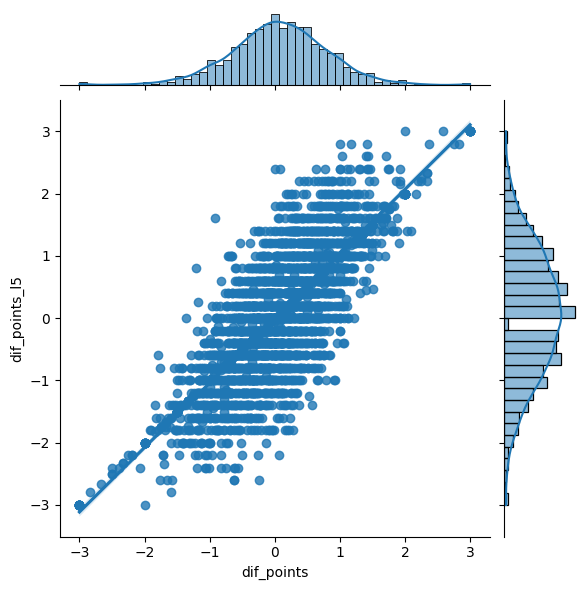

In [47]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

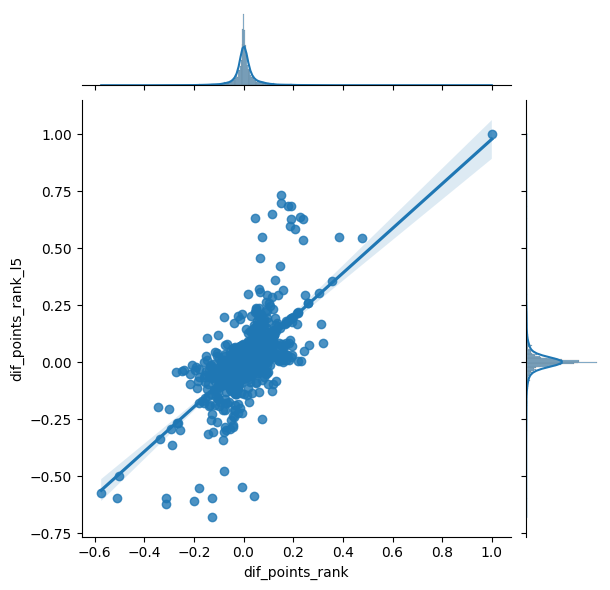

In [48]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l5', kind="reg")
plt.show()

因为排名差异，积分差异，排名平均积分差异这两个版本（所有数据、最近5场比赛）并不那么相似，因此我们决定两个版本都使用。因此，我们特征筛选最后的结果是：
    rank_dif
    goals_dif
    goals_dif_l5
    goals_suf_dif
    goals_suf_dif_l5
    dif_rank_agst
    dif_rank_agst_l5
    goals_per_ranking_dif
    dif_points_rank
    dif_points_rank_l5
    is_friendly



In [49]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [50]:
model_db = create_db(df)
model_db

home_team         away_team  target  rank_dif  goals_dif  goals_dif_l5  \
4       Barbados              Cuba       1     -21.0   2.000000           2.0   
6       Barbados              Cuba       1     -21.0   1.000000           1.0   
31      Mongolia              Guam       1      -4.0   4.000000           4.0   
32         Nepal            Bhutan       0     -22.0   1.000000           1.0   
33    Bangladesh          Pakistan       0      -7.0  -1.000000          -1.0   
...          ...               ...     ...       ...        ...           ...   
3334      Norway            Serbia       1      11.0  -0.038095          -0.8   
3335      Sweden          Slovenia       1     -45.0   0.030812           0.2   
3336      Kosovo            Cyprus       0      -2.0   0.667341           0.6   
3337      Greece  Northern Ireland       0      -9.0   0.067653           0.2   
3338        Fiji   Solomon Islands       0      26.0  -1.119048          -0.6   

      goals_suf_dif  goals_suf_dif_l5  goals_per_ranking_dif  dif_rank_agst  \
4          1.000000               1.0               0.037037     -92.000000   
6          0.500000               0.5               0.008511     -35.500000   
31        -1.000000              -1.0               0.021622       0.000000   
32         0.000000               0.0               0.004975       7.000000   
33        -0.500000              -0.5              -0.007200      30.500000   
...             ...               ...                    ...            ...   
3334      -0.230159               0.0              -0.005282       9.014286   
3335       0.137255               0.2               0.009459     -25.102241   
3336      -0.463094               0.0               0.007625       7.037917   
3337      -0.369979              -1.2              -0.002915      16.024841   
3338      -0.634921              -0.8              -0.006351      -7.476190   

      dif_rank_agst_l5  dif_points_rank  dif_points_rank_l5  is_friendly_0  \
4                -92.0         0.018519            0.018519              0   
6                -35.5         0.008897            0.008897              0   
31                 0.0         0.016216            0.016216              1   
32                 7.0         0.000000            0.000000              1   
33                30.5        -0.010437           -0.010437              1   
...                ...              ...                 ...            ...   
3334              -3.4        -0.011343            0.016348              1   
3335              10.2         0.022485           -0.020314              1   
3336               1.6         0.008791           -0.002827              1   
3337               0.6         0.027775            0.018570              1   
3338               5.8        -0.000581           -0.003519              1   

      is_friendly_1  
4                 1  
6                 1  
31                0  
32                0  
33                0  
...             ...  
3334              0  
3335              0  
3336              0  
3337              0  
3338              0  

[3204 rows x 15 columns]

建立预测模型

    通过上面步骤，我们已经得到了一个具有预测能力的数据集，我们可以开始我们的建模了
    在本次任务中，我们将建立两个模型（RFC、GBDT）。最终选择召回率最佳的模型作为我们的预测模型。

In [51]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

In [52]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [54]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [55]:
gb = gb_cv.best_estimator_
gb

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=200, random_state=5)

In [57]:
params_rf = {"max_depth": [20],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [188]:
rf = rf_cv.best_estimator_
rf

RandomForestClassifier(max_depth=20, max_leaf_nodes=175, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=250, random_state=1)

模型对比

在这里，我们使用混淆矩阵以及ROC曲线进行模型对比

In [59]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [60]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

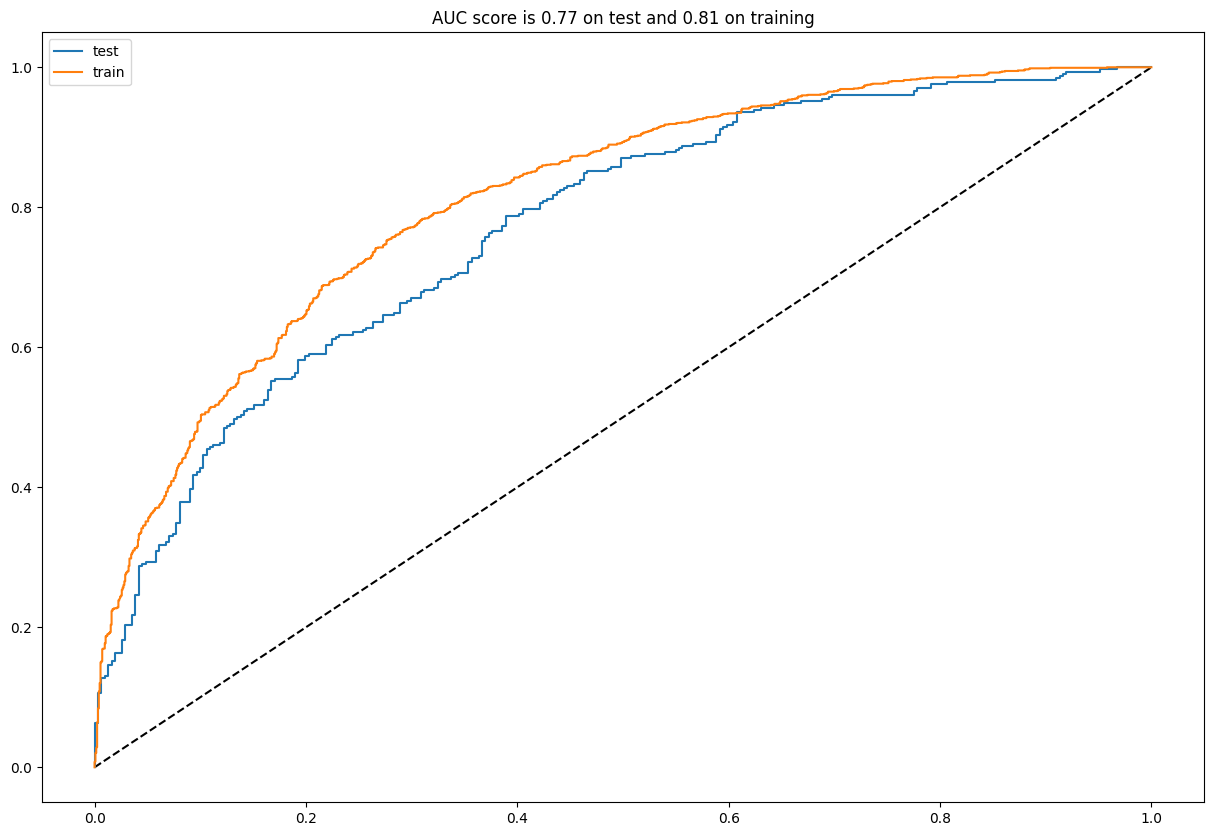

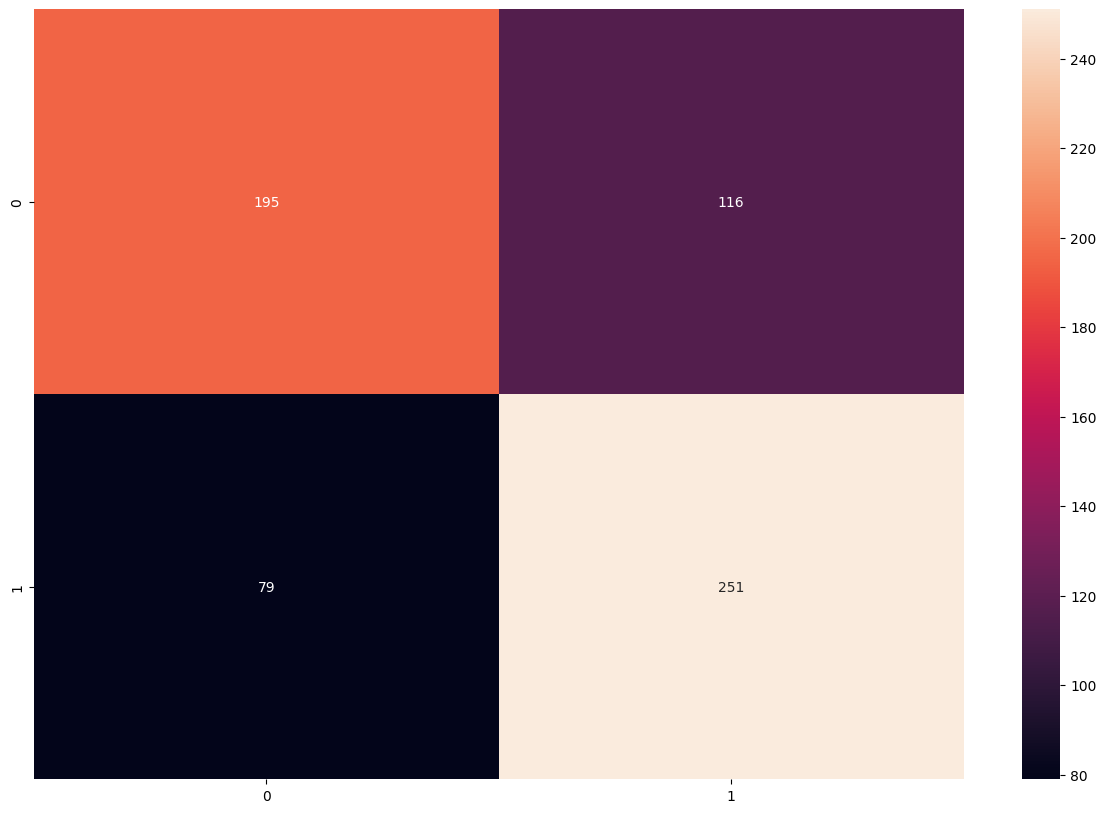

In [61]:
analyze(gb)

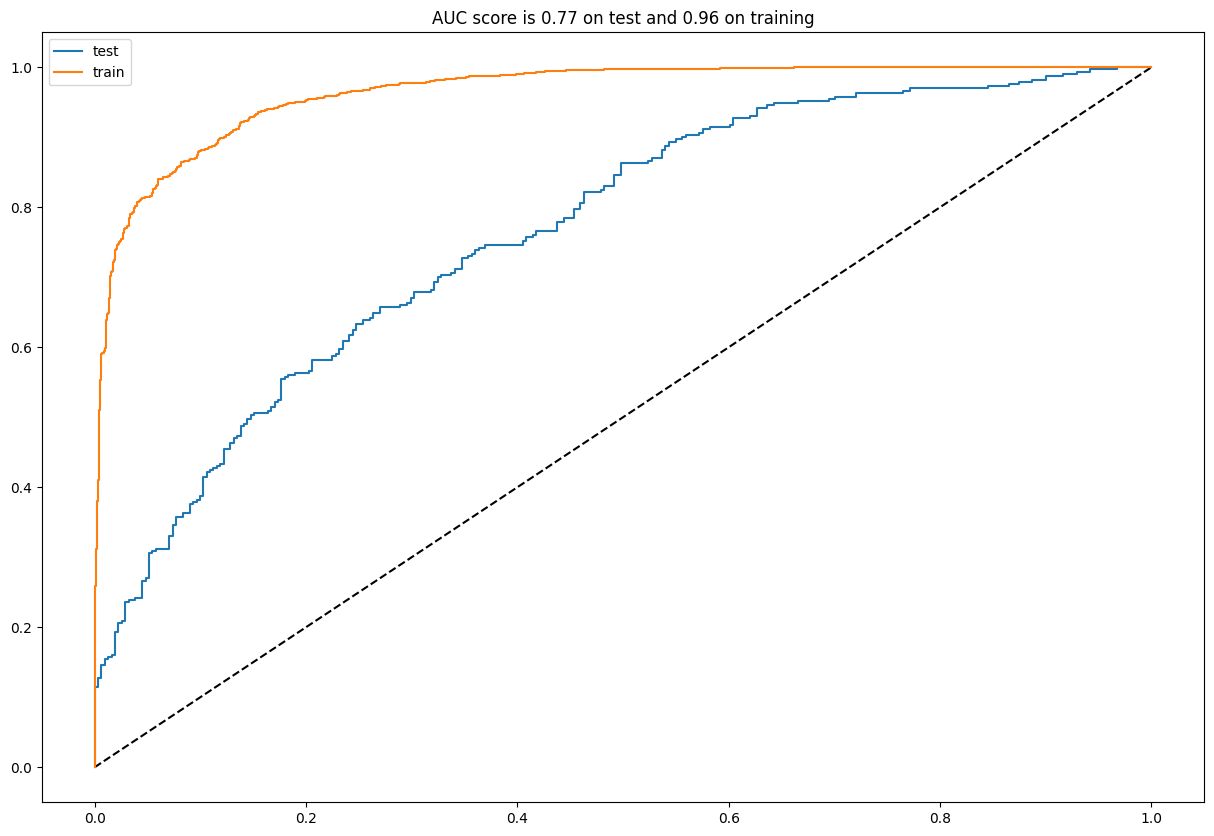

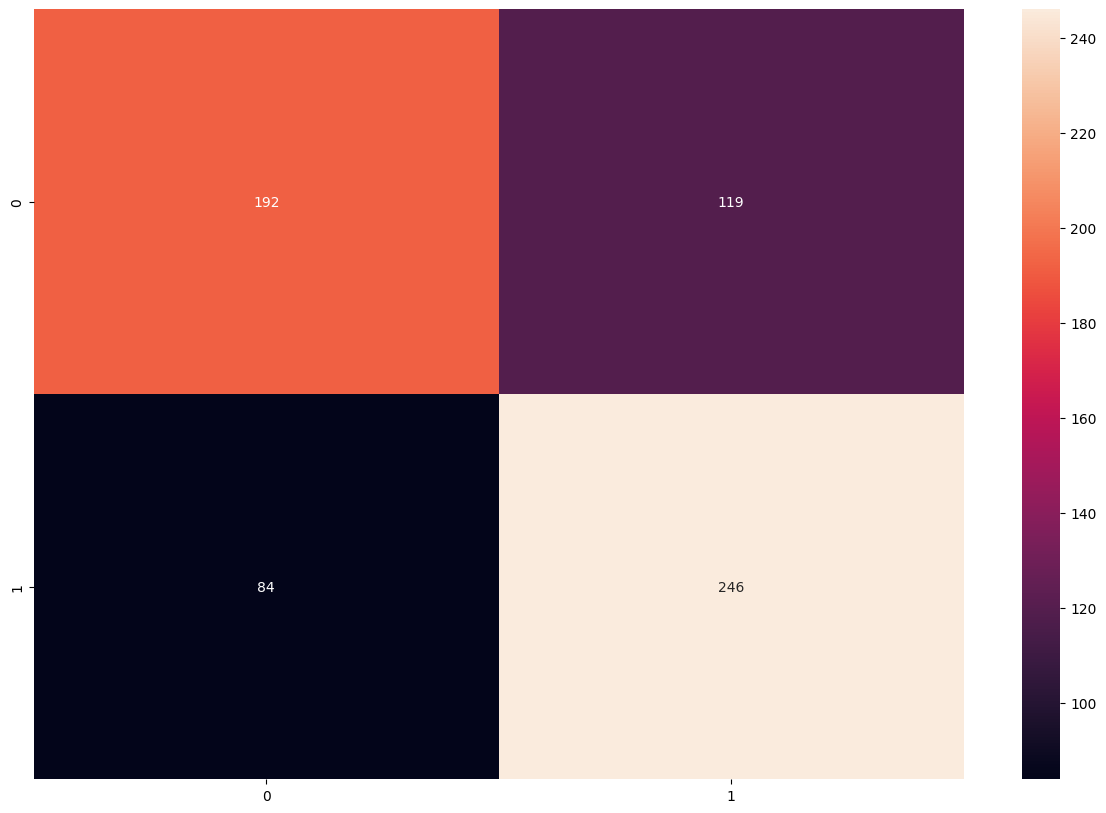

In [62]:
analyze(rf)

通过分析发现，随机森林模型或许稍微好一点，但似乎泛化能力不行。因此我们将使用GBDT模型

世界杯模拟

    第一件事是创建FIFA世界杯游戏
    要做到这一点，我们得先在维基百科中获得球队和小组赛阶段的比赛



In [189]:
from operator import itemgetter
dfs = pd.read_html('2022 FIFA World Cup - Wikipedia.html')

In [190]:
from collections.abc import Iterable

for i in range(len(dfs)):
    df = dfs[i]
    cols = list(df.columns.values)
    
    if isinstance(cols[0], Iterable):
        if any("Tie-breaking criteria" in c for c in cols):
            start_pos = i+1
            end_pos = start_pos + 7*8 #fixed

#        if any("Match 46" in c for c in cols):
#            end_pos = i+1 #wiki百科中内容变动导致失效

matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[start_pos].iloc[:, 1].values)]

for i in range(start_pos+1, end_pos, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        
        matches.append((groups[group_count], team_1, team_2))
    else:
        group_count+=1
        table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

小组赛

以上，我们存储了各球队在小组赛中的积分以及它在每一场比赛中获胜的概率。特别地，当两支球队的积分相同时，球队获胜概率的均值将被用作平局。 接下来，我们将使用上一场比赛的数据作为每支队伍参赛队伍的数据。如，巴西对塞尔维亚，巴西的数据就是他们在上一场比赛中的数据，塞尔维亚的数据也是如此。

In [191]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1] #使用最后一场比赛的数据
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

In [192]:
table

{'A': [['Netherlands', 0, []],
  ['Senegal', 0, []],
  ['Ecuador', 0, []],
  ['Qatar', 0, []]],
 'B': [['England', 0, []],
  ['United States', 0, []],
  ['Iran', 0, []],
  ['Wales', 0, []]],
 'C': [['Argentina', 0, []],
  ['Poland', 0, []],
  ['Mexico', 0, []],
  ['Saudi Arabia', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Tunisia', 0, []],
  ['Denmark', 0, []]],
 'E': [['Japan', 0, []],
  ['Spain', 0, []],
  ['Germany', 0, []],
  ['Costa Rica', 0, []]],
 'F': [['Morocco', 0, []],
  ['Croatia', 0, []],
  ['Belgium', 0, []],
  ['Canada', 0, []]],
 'G': [['Brazil', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []],
  ['Serbia', 0, []]],
 'H': [['Portugal', 0, []],
  ['South Korea', 0, []],
  ['Uruguay', 0, []],
  ['Ghana', 0, []]]}

In [193]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)
    
    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("%s组 : "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+"  %s组开始分析 "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print(" %s组 - %s VS. %s:  %s获胜 概率为 %.2f"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print(" %s组 - %s vs. %s: 平局"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print(" %s组 : "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



----------  A组开始分析 ----------
 A组 - Qatar VS. Ecuador:  Ecuador获胜 概率为 0.62
 A组 - Senegal VS. Netherlands:  Netherlands获胜 概率为 0.62
 A组 - Qatar VS. Senegal:  Senegal获胜 概率为 0.60
 A组 - Netherlands VS. Ecuador:  Netherlands获胜 概率为 0.72
 A组 - Ecuador vs. Senegal: 平局
 A组 - Netherlands VS. Qatar:  Netherlands获胜 概率为 0.77


A组 : 
Netherlands -------- 9
Senegal -------- 4
Ecuador -------- 4
Qatar -------- 0


----------  B组开始分析 ----------
 B组 - England VS. Iran:  England获胜 概率为 0.61
 B组 - United States vs. Wales: 平局
 B组 - Wales vs. Iran: 平局
 B组 - England VS. United States:  England获胜 概率为 0.62
 B组 - Wales VS. England:  England获胜 概率为 0.65
 B组 - Iran VS. United States:  United States获胜 概率为 0.61


B组 : 
England -------- 9
United States -------- 4
Wales -------- 2
Iran -------- 1


----------  C组开始分析 ----------
 C组 - Argentina VS. Saudi Arabia:  Argentina获胜 概率为 0.78
 C组 - Mexico vs. Poland: 平局
 C组 - Poland VS. Saudi Arabia:  Poland获胜 概率为 0.70
 C组 - Argentina VS. Mexico:  Argentina获胜 概率为 0.68
 C组 - Pol

季后赛

In [69]:
advanced = advanced_group

In [194]:
advanced

[['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Mexico'],
 ['France', 'Denmark'],
 ['Spain', 'Germany'],
 ['Belgium', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'Uruguay']]

In [197]:
playoffs = {"第十六场比赛": [], "四分之一决赛": [], "半决赛": [], "决赛": []}

In [198]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "第十六场比赛":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        

In [200]:
playoffs['第十六场比赛'] = [['Netherlands', 'United States'],
  ['Argentina', 'Australia'],
  ['Japan', 'Croatia'],
  ['Brazil', 'South Korea'],
  ['Senegal', 'England'],
  ['Poland', 'France'],
  ['Morocco', 'Spain'],
  ['Switzerland', 'Portugal']]

In [205]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "第十六场比赛":
        # control = []
        # for a in range(0, len(advanced*2), 1):
        #     if a < len(advanced):
        #         if a % 2 == 0:
        #             control.append((advanced*2)[a][0])
        #         else:
        #             control.append((advanced*2)[a][1])
        #     else:
        #         if a % 2 == 0:
        #             control.append((advanced*2)[a][1])
        #         else:
        #             control.append((advanced*2)[a][0])

        # playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        playoffs['第十六场比赛'] = [['Netherlands', 'United States'],
  ['Argentina', 'Australia'],
  ['Japan', 'Croatia'],
  ['Brazil', 'South Korea'],
  ['Senegal', 'England'],
  ['Poland', 'France'],
  ['Morocco', 'Spain'],
  ['Switzerland', 'Portugal']]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("开始模拟 %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s VS. %s: %s 晋级 概率为 %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s VS. %s: %s 晋级 概率为 %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        #playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        playoffs['四分之一决赛'] = [['Netherlands', 'Argentina'], ['Croatia', 'Brazil'], ['England', 'France'], ['Morocco', 'Portugal']]
        playoffs['半决赛'] = [['Argentina','Croatia'],['France','Morocco']]
        playoffs['决赛'] = [['Argentina','France']]
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("开始模拟 %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s VS. %s: %s 晋级 概率为 %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s VS. %s: %s 晋级 概率为 %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p

----------
开始模拟 第十六场比赛
----------


Netherlands VS. United States: Netherlands 晋级 概率为 0.55
Argentina VS. Australia: Argentina 晋级 概率为 0.75
Japan VS. Croatia: Croatia 晋级 概率为 0.60
Brazil VS. South Korea: Brazil 晋级 概率为 0.75
Senegal VS. England: England 晋级 概率为 0.63
Poland VS. France: France 晋级 概率为 0.67
Morocco VS. Spain: Spain 晋级 概率为 0.66
Switzerland VS. Portugal: Portugal 晋级 概率为 0.55
----------
开始模拟 四分之一决赛
----------


Netherlands VS. Argentina: Argentina 晋级 概率为 0.50
Croatia VS. Brazil: Brazil 晋级 概率为 0.69
England VS. France: France 晋级 概率为 0.51
Morocco VS. Portugal: Portugal 晋级 概率为 0.69
----------
开始模拟 半决赛
----------


Argentina VS. Croatia: Argentina 晋级 概率为 0.65
France VS. Morocco: France 晋级 概率为 0.61
----------
开始模拟 决赛
----------


Argentina VS. France: Argentina 晋级 概率为 0.53


In [196]:
playoffs

{'第十六场比赛': [['Netherlands',
   'United States',
   [0.5528767148368134, 0.4471232851631866]],
  ['Argentina', 'Denmark', [0.6308065148328623, 0.36919348516713774]],
  ['Spain', 'Croatia', [0.6177758127400605, 0.38222418725993945]],
  ['Brazil', 'Uruguay', [0.6522612255413693, 0.3477387744586306]],
  ['Senegal', 'England', [0.3687873826198659, 0.631212617380134]],
  ['Mexico', 'France', [0.37780627540399225, 0.6221937245960077]],
  ['Germany', 'Belgium', [0.4930329030475016, 0.5069670969524984]],
  ['Switzerland', 'Portugal', [0.45284342891072965, 0.5471565710892703]]],
 '四分之一决赛': [['Netherlands',
   'Argentina',
   [0.4993608506205713, 0.5006391493794287]],
  ['Spain', 'Brazil', [0.45748561084789224, 0.5425143891521078]],
  ['England', 'France', [0.4937662226260103, 0.5062337773739898]],
  ['Belgium', 'Portugal', [0.45952734317370325, 0.5404726568262967]]],
 '半决赛': [['Argentina', 'Brazil', [0.49987341608307956, 0.5001265839169204]],
  ['France', 'Portugal', [0.46894615983831617, 0.5310

In [73]:
!pip install pydot pydot-ng graphviz

未安装graphviz

In [75]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()

FileNotFoundError: [Errno 2] "twopi" not found in path.

<Figure size 1500x1000 with 0 Axes>